In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from gp_trajectory_compensation import TrajectoryCompensatorGP
from typing import Optional

### The cell below and the loading function will need to be adapted to take any g-code as input

In [2]:
# Commanded waypoints (units: mm)
x_cmd = np.array([-96.839, -58.761, -20.692, 17.378, 55.433, 93.495, 131.553])
y_cmd = np.array([79.866, 79.841, 79.816, 79.791, 79.776, 79.751, 79.726])
z_cmd = np.array([2.91, 3.00, 3.05, 2.95, 2.85, 2.87, 2.89])

# Time vector for waypoints (units: seconds)
t_waypoints = np.linspace(0, 7, 7)  # 7 seconds total

In [3]:
def load_and_preprocess_experiments(experiment_names, x_cmd, y_cmd, z_cmd, t_waypoints):
    observed_xyz_list = []
    commanded_xyz_list = []
    desired_xyz_list = []
    t_sec_list = []
    for i, exp_name in enumerate(experiment_names):
        df = pd.read_csv(f'{exp_name}.csv')
        t_sec_i = df['Time'].values / 1000  # Convert to seconds
        observed_xyz_i = df[['x', 'y', 'z']].values
        T_i = len(t_sec_i)
        x_interp = interp1d(t_waypoints, x_cmd, kind='linear', fill_value='extrapolate')
        y_interp = interp1d(t_waypoints, y_cmd, kind='linear', fill_value='extrapolate')
        z_interp = interp1d(t_waypoints, z_cmd, kind='linear', fill_value='extrapolate')
        commanded_xyz_i = np.column_stack([
            x_interp(t_sec_i),
            y_interp(t_sec_i),
            z_interp(t_sec_i)
        ])
        x_desired_i = np.linspace(0, 300, T_i)  # 0 to 300 mm
        y_desired_i = np.full(T_i, 900)        # 900 mm
        z_desired_i = np.full(T_i, 800)        # 800 mm
        desired_xyz_i = np.column_stack([x_desired_i, y_desired_i, z_desired_i])
        observed_xyz_list.append(observed_xyz_i)
        commanded_xyz_list.append(commanded_xyz_i)
        desired_xyz_list.append(desired_xyz_i)
        t_sec_list.append(t_sec_i + i * max(t_sec_i))
    observed_xyz_all = np.concatenate(observed_xyz_list, axis=0)
    commanded_xyz_all = np.concatenate(commanded_xyz_list, axis=0)
    desired_xyz_all = np.concatenate(desired_xyz_list, axis=0)
    t_sec_all = np.concatenate(t_sec_list, axis=0)
    return (
        observed_xyz_all, commanded_xyz_all, desired_xyz_all, t_sec_all,
        observed_xyz_list, commanded_xyz_list, desired_xyz_list, t_sec_list
    )

In [4]:
# Select the samples to load
experiment_names = ["experiment_2", "experiment_3"] # Select as many sample as needed, after ensuring to have extracted them through the script "sample_extraction.ipynb"
(
    observed_xyz_all, commanded_xyz_all, desired_xyz_all, t_sec_all,
    observed_xyz_list, commanded_xyz_list, desired_xyz_list, t_sec_list
) = load_and_preprocess_experiments(experiment_names, x_cmd, y_cmd, z_cmd, t_waypoints)

In [5]:
# Train the GP (time in seconds, distance in mm)
comp = TrajectoryCompensatorGP(include_vel=True, dt_hint=0.001, kernel='tiny', damping=1.0)
comp.fit(desired_xyz_all, commanded_xyz_all, observed_xyz_all, t_sec_all)

In [ ]:
# Predict and compensate
predicted_error_all = comp.predict_error(commanded_xyz_all, desired_xyz_all, t_sec_all)
compensated_cmd_all = comp.compensate(desired_xyz_all, t_sec=t_sec_all, n_iter=3)

In [7]:
compensated_cmd_list = []
for des, t in zip(desired_xyz_list, t_sec_list):
    compensated_cmd_i = comp.compensate(des, t_sec=t, n_iter=3)
    compensated_cmd_list.append(compensated_cmd_i)

In [8]:
t_sec_ms_list = [t * 1000 for t in t_sec_list]  # Convert time to ms for all samples

In [30]:
def plot_sample_trajectories(
    desired_xyz_list, commanded_xyz_list, observed_xyz_list, compensated_cmd_list, t_sec_ms_list
):
    for i, (des, cmd, obs, comp, t_ms) in enumerate(zip(desired_xyz_list, commanded_xyz_list, observed_xyz_list, compensated_cmd_list, t_sec_ms_list)):
        # Center each trajectory around its own mean
        mean_y_target = des[:, 1].mean()
        mean_y_cmd = cmd[:, 1].mean()
        mean_y_obs = obs[:, 1].mean()
        mean_y_comp = comp[:, 1].mean()

        mean_z_target = des[:, 2].mean()
        mean_z_cmd = cmd[:, 2].mean()
        mean_z_obs = obs[:, 2].mean()
        mean_z_comp = comp[:, 2].mean()

        # No offsets (all set to 0)
        offsets_y = [0, 0, 0, 0]
        offsets_z = [0, 0, 0, 0]

        # Center and offset y trajectories
        y_target_centered = des[:, 1] - mean_y_target + offsets_y[0]
        y_cmd_centered = cmd[:, 1] - mean_y_cmd + offsets_y[1]
        y_obs_centered = obs[:, 1] - mean_y_obs + offsets_y[2]
        y_comp_centered = comp[:, 1] - mean_y_comp + offsets_y[3]

        # Center and offset z trajectories
        z_target_centered = des[:, 2] - mean_z_target + offsets_z[0]
        z_cmd_centered = cmd[:, 2] - mean_z_cmd + offsets_z[1]
        z_obs_centered = obs[:, 2] - mean_z_obs + offsets_z[2]
        z_comp_centered = comp[:, 2] - mean_z_comp + offsets_z[3]

        # Plot
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # y trajectories
        axes[0].plot(t_ms, y_target_centered, label='Target y', color='green')
        axes[0].plot(t_ms, y_cmd_centered, label='Commanded y', color='red', linestyle='--')
        axes[0].plot(t_ms, y_obs_centered, label='Observed y', color='blue')
        axes[0].plot(t_ms, y_comp_centered, label='Compensated y', color='purple', linestyle=':')
        axes[0].tick_params(labelbottom=True)  # Show x-axis labels
        axes[0].set_ylabel('y (mm)')
        axes[0].set_ylim(-0.2, 0.2)  # Zoom in to show small variations
        axes[0].legend()
        axes[0].grid(True)
        axes[0].set_title(f'Sample {i+1}: y Trajectories (Centered)')

        # z trajectories
        axes[1].plot(t_ms, z_target_centered, label='Target z', color='green')
        axes[1].plot(t_ms, z_cmd_centered, label='Commanded z', color='red', linestyle='--')
        axes[1].plot(t_ms, z_obs_centered, label='Observed z', color='blue')
        axes[1].plot(t_ms, z_comp_centered, label='Compensated z', color='purple', linestyle=':')
        axes[1].tick_params(labelbottom=True)  # Show x-axis labels
        axes[1].set_ylabel('z (mm)')
        axes[1].set_ylim(-0.2, 0.2)  # Zoom in to show small variations
        axes[1].set_xlabel('Time (ms)')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_title(f'Sample {i+1}: z Trajectories (Centered)')

        plt.suptitle(f'Sample {i+1}: Trajectory Comparison (Centered)')
        plt.tight_layout()
        plt.show()

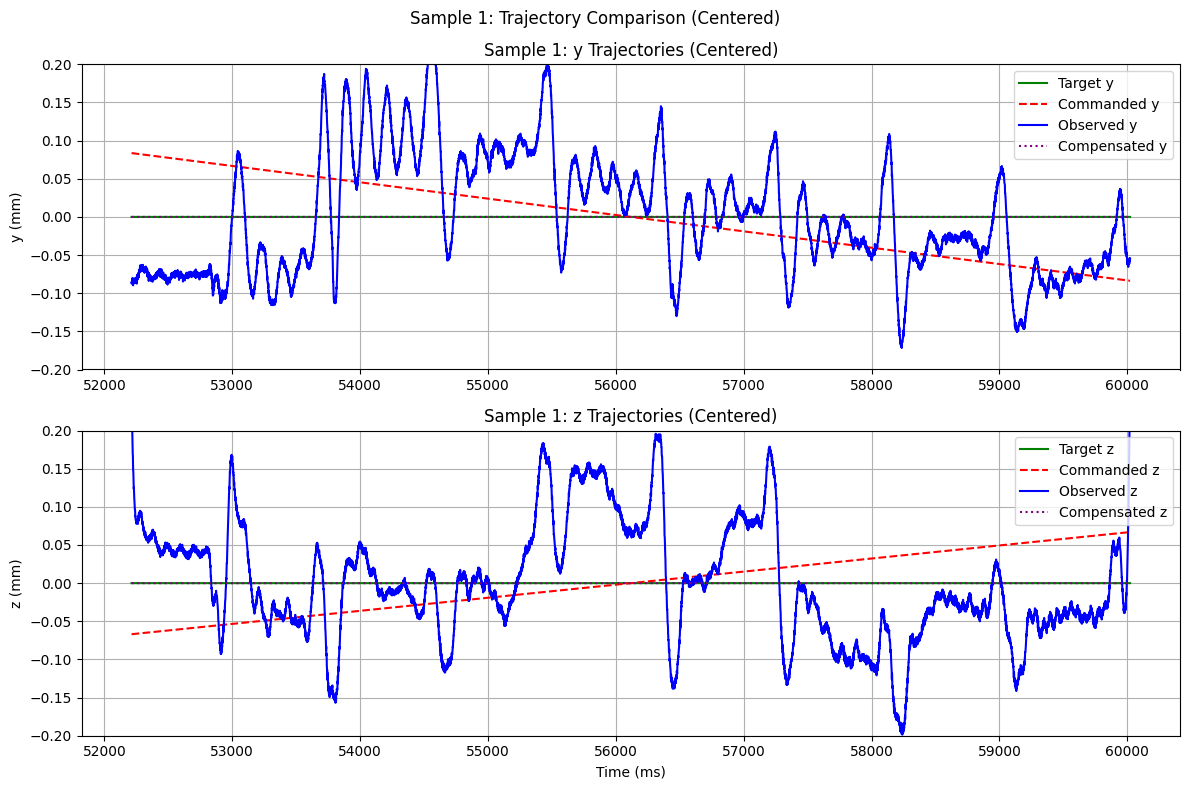

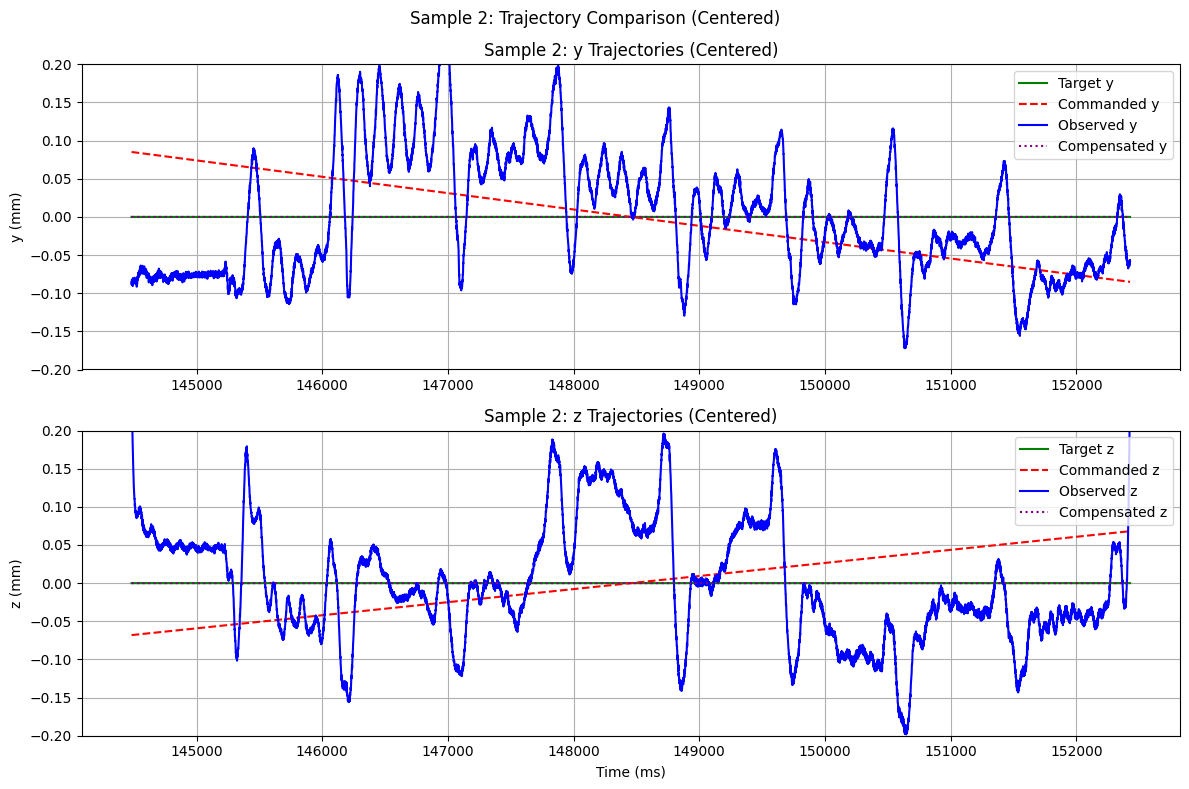

In [31]:
plot_sample_trajectories(desired_xyz_list, commanded_xyz_list, observed_xyz_list, compensated_cmd_list, t_sec_ms_list)

----------------------------------------